# Radial Basis Functions and Feed Forward Networks

Radial basis function networks are *not* feed forward networks.  Feed forward networks are typically used for classification whereas radial bases function networks are used for *fitting* contiguous functions.

## Environment Preparation

Upgrade and install packages.  Add more packages as required in your environment.

In [5]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.3MB 913kB/s ta 0:00:01    73% |███████████████████████▌        | 962kB 2.9MB/s eta 0:00:01
pyasn1-modules 0.2.2 has requirement pyasn1<0.5.0,>=0.4.1, but you'll have pyasn1 0.1.9 which is incompatible.
msrest 0.5.4 has requirement requests~=2.16, but you'll have requests 2.14.2 which is incompatible.
azure-cli-interactive 0.3.24 has requirement six~=1.11.0, but you'll have six 1.10.0 which is incompatible.
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


In [ ]:
!pip install -U keras

In [ ]:
!pip install -U theano

In [ ]:
!pip install -U tensorflow

    100% |████████████████████████████████| 51.1MB 4.8kB/s ta 0:00:01  4% |█▍                              | 2.3MB 2.2MB/s eta 0:00:23    15% |████▉                           | 7.7MB 3.1MB/s eta 0:00:14    15% |█████                           | 8.1MB 2.3MB/s eta 0:00:19    21% |██████▉                         | 10.9MB 2.9MB/s eta 0:00:14    23% |███████▌                        | 12.0MB 3.1MB/s eta 0:00:13    23% |███████▋                        | 12.2MB 3.0MB/s eta 0:00:13    30% |█████████▉                      | 15.7MB 1.1MB/s eta 0:00:33    30% |█████████▉                      | 15.8MB 789kB/s eta 0:00:45    36% |███████████▊                    | 18.8MB 2.4MB/s eta 0:00:14    37% |████████████                    | 19.3MB 379kB/s eta 0:01:24    45% |██████████████▋                 | 23.3MB 766kB/s eta 0:00:37    50% |████████████████▎               | 26.0MB 915kB/s eta 0:00:28    52% |████████████████▋               | 26.6MB 1.8MB/s eta 0:00:14    52% |████████████████▊              

In [ ]:
!pip install -U numpy

### Where am I?

One goal is to allow the notebooks to exist and run anywhere.  The following code, while somewhat kludgy, will at least allow us to guess where the notebook is running.

In [8]:
env = None
colaboratory_flag = False
try:
    # This will work for everything but Google Colaboratory since the utility is somewhere on Google Drive
    # which is not yet mounted and so it is not reachable.
    #
    from utilities.detect_environment import detect_environment

    env = detect_environment()

    print('Detected Environment: {}'.format(env))
    if env.detected_environment == utilities.detect_environment.COLABORATORY:
        colaboratory_flag = True
    
except:
    # Check if on Colaboratory
    import os
    try:
        os.environ['DATALAB_SETTINGS_OVERRIDES']
        colaboratory_flag = True
    except:
        pass
        

Detected Environment: Microsoft Azure Notebook


If running on Google Colaboratory, mount Google Drive so we can use our utilities.  See [https://gist.github.com/osmszk/4d170bb100209000ad362f1d5bf7c927](https://gist.github.com/osmszk/4d170bb100209000ad362f1d5bf7c927).  If on Colaboratory, the code will mount your Google Drive at /content/drive.

In [9]:
if colaboratory_flag:
    #colab
    # google-drive-ocamlfuse
    # https://github.com/astrada/google-drive-ocamlfuse
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
    !apt-get update -qq 2>&1 > /dev/null
    !apt-get -y install -qq google-drive-ocamlfuse fuse

    # Colab Auth token
    from google.colab import auth
    auth.authenticate_user()

    # Drive FUSE library credential
    from oauth2client.client import GoogleCredentials
    creds = GoogleCredentials.get_application_default()
    import getpass
    !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
    vcode = getpass.getpass()
    !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

    # drive/ Google Drive
    !mkdir -p drive
    !google-drive-ocamlfuse drive

## Keras Backend

Choose the backend to use before importing any Keras libraries.  Microsoft's *cntk* has a lot of dependencies on Microsoft's C++ software, etc. and may not be appropriate for the environment you want to run in.  In fact, when I tried it on Azure Free Notebooks in July 2018, it crashed!

TensorFlow - [https://www.tensorflow.org/](https://www.tensorflow.org/)

Theano - [http://deeplearning.net/software/theano/](http://deeplearning.net/software/theano)

In [12]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['KERAS_BACKEND'] = 'theano'

In [11]:
if os.environ['KERAS_BACKEND'] == 'cntk' and env.detected_environment == detect_environment.AZURE:
    !pip install -U cntk

Requirement already up-to-date: cntk in /home/nbuser/anaconda3_420/lib/python3.5/site-packages (2.5.1)


Make results reproducible by setting a fixed seed for random number generation.

In [13]:
import numpy as np

# fix random seed for reproducibility
seed = 155
np.random.seed(seed)

## RBF Layer for Keras
Keras doesn't provide RBF layers natively.  [Petra Vidnerova](https://github.com/PetraVidnerova/rbf_keras) does provide an RBF layer - this demonstrates how to write custom layers in Keras.

In [14]:
from keras.initializers import Initializer
import numpy as np 

class InitFromFile(Initializer):
    """ Initialize the weights by loading from file.
    # Arguments
        filename: name of file, should by .npy file 
    """
    def __init__(self, filename):
        self.filename = filename 

    def __call__(self, shape, dtype=None):
        with open(self.filename, "rb") as f:
            X = np.load(f)
        assert shape == X.shape 
        return X 

    def get_config(self):
        return {
            'filename': self.filename
        }

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using CNTK backend
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/keras/backend/cntk_backend.py:19: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


In [15]:
import random 
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Orthogonal, Constant
import numpy as np

class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows 
          are taken as centers)
    """
    def __init__(self, X):
        self.X = X 

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx,:]

        
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units. 
    # Example
 
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X), 
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas 
    """
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas 
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer 
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.centers = self.add_weight(name='centers', 
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_betas),
                                     trainable=True)
            
        super(RBFLayer, self).build(input_shape)  

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp( -self.betas * K.sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Creating an RBF **Network**

Similar to our feed forward case, we write some helper functions.  First ```run_model``` will create a RBFN and fit it and calculate the fitting metrics (RMSE).

In [16]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


RBFs are really designed to work with continuous functions.  So one problem to consider is fitting (continuous) datasets.  For simplicity - we can simply just generate a dataset using some curve function like sin.  What's nice about using a real function is that we can generate what should be other data points with ease .

One question that should be asked is if it is possible to extrapolate values, that is, perform prediction outside of the training range?  We shall discover that this is not possible, but it is a good question.

## One-Dimensional Example

In [17]:
stepsize = 0.05
test0, testf = -1.0, 10.0
train0, trainf = test0-stepsize/2.0, testf+stepsize/2.0

# Generate a data set from the function sin(2*pi*t)
def test_function(x):
  return np.sin(2*math.pi*x)

ptrain_X = np.arange(test0, testf, stepsize)
ptrain_Y = test_function(ptrain_X)

# And for validation, let's create a somewhat overlapping
# dataset, but are going to let this dataset range go to 2.
ptest_X = np.arange(train0, trainf, 2*stepsize)
ptest_Y = test_function(ptest_X)

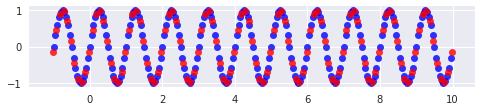

In [18]:
sns.set(style="darkgrid")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.regplot(x=ptrain_X, y=ptrain_Y, fit_reg=False, color='blue')
ax = sns.regplot(x=ptest_X, y=ptest_Y, fit_reg=False, color='red')

Define functions which will create the model, train it, and then test it.  First, a function to create a model.

In [19]:
def create_model(X_train, hidden_layer_size, dim=1, betas=3.0, optimizer = None,
                 lr=0.01):
    np.random.seed(seed)
    model = Sequential() # create model
    
    # Create an RBF hidden layer - this uses the Gaussian as the closeness function.
    model.add(RBFLayer(hidden_layer_size,
                       initializer=InitCentersRandom(X_train), 
                       betas=betas,
                       input_shape=(dim,))) # hidden layer
    
    model.add(Dense(1)) # output layer
    # Default learning rate is 0.001.  For this problem, we can get very aggressive
    # on the learning rate.
    if optimizer is None:
        optimizer = keras.optimizers.Adam(lr=lr)
    
    # For regression (which this is closest to), use RMSE, not cross-entropy.
    model.compile(loss='mean_squared_error',optimizer=optimizer)
    return model

In [20]:
def run_model(X_train, Y_train, X_test, Y_test, hidden_layer_size, epochs=1000):
    np.random.seed(seed)
    model = Sequential() # create model
    
    # Create an RBF hidden layer - this uses the Gaussian as the closeness function.
    model.add(RBFLayer(hidden_layer_size,
                       initializer=InitCentersRandom(X_train), 
                       betas=3.0,
                       input_shape=(1,))) # hidden layer
    
    model.add(Dense(1)) # output layer
    # Default learning rate is 0.001.  For this problem, we can get very aggressive
    # on the learning rate.
    adamo = keras.optimizers.Adam(lr=0.01)
    
    # For regression (which this is closest to), use RMSE, not cross-entropy.
    model.compile(loss='mean_squared_error',optimizer=adamo)
    
    # Fit the model
    # verbose=0 suppresses the file writing message
    # note that the fit method expects a list of callbacks
    fitting_log={'loss':[], 'acc':[]}
    
    # Fit in a loop so we can track the test accuracy as we go.
    for i in range(epochs):
        results = model.fit(X_train, Y_train,epochs=1, verbose=0, batch_size=X_train.shape[0],
                            initial_epoch=0)
        fitting_log['loss'].append(results.history['loss'][0])
        y_pred = model.predict(X_train)
        fitting_log['acc'].append(mean_squared_error(Y_train, y_pred))
        
    # Evaluate the model on the test case to see how we did.
    y_tpred = model.predict(X_test)
    return model, fitting_log, mean_squared_error(Y_test, y_tpred)

In [ ]:
# Fit the model
def fit_model(model, X_train, Y_train, X_test, Y_test, epochs=1000):
    # verbose=0 suppresses the file writing message
    # note that the fit method expects a list of callbacks
    fitting_log={'loss':[], 'acc':[]}
    
    # Fit in a loop so we can track the test accuracy as we go.
    for i in range(epochs):
        results = model.fit(X_train, Y_train, epochs=1, verbose=0, batch_size=X_train.shape[0],
                            initial_epoch=0)
        fitting_log['loss'].append(results.history['loss'][0])
        y_pred = model.predict(X_train)
        fitting_log['acc'].append(mean_squared_error(Y_train, y_pred))
        
    # Evaluate the model on the test case to see how we did.
    y_tpred = model.predict(X_test)
    return model, fitting_log, mean_squared_error(Y_test, y_tpred)

Plotter of loss and accuracy.

In [21]:
def plot_nn(fitted_log):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(range(len(fitted_log['loss'])), fitted_log['loss'],linestyle='-', color='blue',label='Training', lw=2)
    ax2.plot(range(len(fitted_log['acc'])), fitted_log['acc'],linestyle='-', color='blue',label='Training', lw=2)
    leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
    ax1.set_xticklabels('')
    #ax1.set_yscale('log')
    ax2.set_xlabel('# Epochs',fontsize=14)
    ax1.set_ylabel('Loss',fontsize=14)
    ax2.set_ylabel('Accuracy',fontsize=14)
    plt.show()

Generates the output results.

In [22]:
def output_results(model, fitting_log, test_deviation):
    # Print a summary of the model
    print(model.summary())
    # Print the fitting log
    nepochs = len(fitting_log['loss'])
    print(len(fitting_log['acc']), nepochs)
    print('Training loss, accuracy:', [fitting_log['loss'][nepochs-2:nepochs-1], fitting_log['acc'][nepochs-2:nepochs-1]])
    plot_nn(fitting_log)
    print('Test set metric (RMSE): {}'.format(test_deviation))

Properly shape the data.

In [23]:
train_X = np.transpose(np.reshape(ptrain_X, (1,-1)))
train_Y = np.transpose(np.reshape(ptrain_Y, (1,-1)))
test_X = np.transpose(np.reshape(ptest_X, (1,-1)))
test_Y = np.transpose(np.reshape(ptest_Y, (1,-1)))

Try a hidden layer with only five nodes.

In [24]:
model_5, fitting_log_5, test_deviation_5 = run_model(train_X, train_Y, test_X, test_Y, 5, epochs=1000)

ValueError: Axis 'Axis('staticAxisIdx=-2')' is out of bounds for the rank '1' it applies to.

[CALL STACK]
[0x7ff706ca1419]                                                       + 0x8a1419
[0x7ff706d01184]    CNTK::  NormalizeStaticAxis  (CNTK::Axis&,  unsigned long) + 0x134
[0x7ff706d01218]    CNTK::  NormalizeStaticAxis  (CNTK::Axis&,  CNTK::NDShape const&) + 0x58
[0x7ff706cf5520]    CNTK::PrimitiveFunction::  InferOutputs  (std::vector<CNTK::Variable,std::allocator<CNTK::Variable>>&) + 0x34a0
[0x7ff706ca76f4]                                                       + 0x8a76f4
[0x7ff74180ea99]                                                       + 0xea99
[0x7ff706ca401e]    CNTK::Function::  InitOutputs  ()                  + 0x6e
[0x7ff706d3b81d]    CNTK::CompositeFunction::  InferOutputs  (std::vector<CNTK::Variable,std::allocator<CNTK::Variable>>&) + 0xd
[0x7ff706ca76f4]                                                       + 0x8a76f4
[0x7ff74180ea99]                                                       + 0xea99
[0x7ff706ca401e]    CNTK::Function::  InitOutputs  ()                  + 0x6e
[0x7ff706cab6f7]    CNTK::  AsComposite  (std::shared_ptr<CNTK::Function> const&,  std::__cxx11::basic_string<wchar_t,std::char_traits<wchar_t>,std::allocator<wchar_t>> const&) + 0x5b7
[0x7ff706cb1a59]    CNTK::  UnaryOp  (CNTK::PrimitiveOpType,  CNTK::Variable const&,  CNTK::Dictionary&&,  std::__cxx11::basic_string<wchar_t,std::char_traits<wchar_t>,std::allocator<wchar_t>> const&) + 0x139
[0x7ff706cb2a61]    CNTK::  TransposeAxes  (CNTK::Variable const&,  CNTK::Axis const&,  CNTK::Axis const&,  std::__cxx11::basic_string<wchar_t,std::char_traits<wchar_t>,std::allocator<wchar_t>> const&) + 0xd1
[0x7ff7079a2d19]                                                       + 0x1a2d19
[0x5634ce7a1e0b]    PyCFunction_Call                                   + 0x4b
[0x5634ce7f884c]    PyEval_EvalFrameEx                                 + 0x3fc
[0x5634ce80344d]    PyEval_EvalCodeEx                                  + 0x20d
[0x5634ce804ecf]                                                       + 0x1afecf
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce7faf1c]    PyEval_EvalFrameEx                                 + 0x2acc
[0x5634ce7fdccf]    PyEval_EvalFrameEx                                 + 0x587f
[0x5634ce7f8f00]    PyEval_EvalFrameEx                                 + 0xab0
[0x5634ce80344d]    PyEval_EvalCodeEx                                  + 0x20d
[0x5634ce804ecf]                                                       + 0x1afecf
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce7faf1c]    PyEval_EvalFrameEx                                 + 0x2acc
[0x5634ce803d99]    PyEval_EvalCodeEx                                  + 0xb59
[0x5634ce804cf4]                                                       + 0x1afcf4
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce79f83f]                                                       + 0x14a83f
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce7b7897]                                                       + 0x162897
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce7fd212]    PyEval_EvalFrameEx                                 + 0x4dc2
[0x5634ce7f8f00]    PyEval_EvalFrameEx                                 + 0xab0
[0x5634ce7fd660]    PyEval_EvalFrameEx                                 + 0x5210
[0x5634ce80344d]    PyEval_EvalCodeEx                                  + 0x20d
[0x5634ce80436c]    PyEval_EvalCode                                    + 0x1c
[0x5634ce860b7c]                                                       + 0x20bb7c
[0x5634ce7a1e0b]    PyCFunction_Call                                   + 0x4b
[0x5634ce7f884c]    PyEval_EvalFrameEx                                 + 0x3fc
[0x5634ce7fd660]    PyEval_EvalFrameEx                                 + 0x5210 (x2)
[0x5634ce803d99]    PyEval_EvalCodeEx                                  + 0xb59
[0x5634ce804ecf]                                                       + 0x1afecf
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce7faf1c]    PyEval_EvalFrameEx                                 + 0x2acc
[0x5634ce7fdccf]    PyEval_EvalFrameEx                                 + 0x587f
[0x5634ce7fd660]    PyEval_EvalFrameEx                                 + 0x5210
[0x5634ce7f8f00]    PyEval_EvalFrameEx                                 + 0xab0 (x2)
[0x5634ce803d99]    PyEval_EvalCodeEx                                  + 0xb59
[0x5634ce804ecf]                                                       + 0x1afecf
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce7faf1c]    PyEval_EvalFrameEx                                 + 0x2acc
[0x5634ce803d99]    PyEval_EvalCodeEx                                  + 0xb59
[0x5634ce804ecf]                                                       + 0x1afecf
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce7faf1c]    PyEval_EvalFrameEx                                 + 0x2acc
[0x5634ce7fd660]    PyEval_EvalFrameEx                                 + 0x5210
[0x5634ce7f8f00]    PyEval_EvalFrameEx                                 + 0xab0
[0x5634ce80344d]    PyEval_EvalCodeEx                                  + 0x20d
[0x5634ce804ecf]                                                       + 0x1afecf
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce7faf1c]    PyEval_EvalFrameEx                                 + 0x2acc
[0x5634ce7fdccf]    PyEval_EvalFrameEx                                 + 0x587f
[0x5634ce7f8f00]    PyEval_EvalFrameEx                                 + 0xab0
[0x5634ce7fdccf]    PyEval_EvalFrameEx                                 + 0x587f
[0x5634ce7f8f00]    PyEval_EvalFrameEx                                 + 0xab0
[0x5634ce7fd660]    PyEval_EvalFrameEx                                 + 0x5210
[0x5634ce80344d]    PyEval_EvalCodeEx                                  + 0x20d
[0x5634ce80436c]    PyEval_EvalCode                                    + 0x1c
[0x5634ce860b7c]                                                       + 0x20bb7c
[0x5634ce7a1e0b]    PyCFunction_Call                                   + 0x4b
[0x5634ce7f884c]    PyEval_EvalFrameEx                                 + 0x3fc
[0x5634ce7fd660]    PyEval_EvalFrameEx                                 + 0x5210
[0x5634ce80344d]    PyEval_EvalCodeEx                                  + 0x20d
[0x5634ce804d69]                                                       + 0x1afd69
[0x5634ce75609a]    PyObject_Call                                      + 0x3a
[0x5634ce851287]                                                       + 0x1fc287
[0x5634ce861497]    Py_Main                                            + 0x317
[0x5634ce72d2a1]    main                                               + 0xe1
[0x7ff741420830]    __libc_start_main                                  + 0xf0
[0x5634ce805d18]                                                       + 0x1b0d18


In [ ]:
output_results(model_5, fitting_log_5, test_deviation_5)

What happens with a hidden layer with 100 nodes?

In [ ]:
model_100, fitting_log_100, test_deviation_100 = run_model(train_X, train_Y, test_X, test_Y, 100, epochs=500)

In [ ]:
output_results(model_100, fitting_log_100, test_deviation_100)

That is very good - both the training and testing metrics are less than the other versions we tried.

In [ ]:
px0, pxf = -2.0 - stepsize/3, 12 + stepsize/3
predict_X = np.arange(px0, pxf, stepsize)
predict_Y = model_100.predict(predict_X)

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw a density plot for the prediction
ax = sns.regplot(x=predict_X, y=predict_Y, fit_reg=False, color='green')

This is not unexpected actually.  This is a mathematic decay which to some extent reflects the underlying mathematics.  Extrapolation won't work for these fits.  The predictions must be kept in the range of testing and training.  So let's just extend the periods - both for training and testing.